In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 加载数据集
class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pd.read_csv(csv_file, header=None)
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')

mnist_datset = MnistDataset('~/dataset/MNIST/mnist_test.csv')

In [3]:
# 判别器
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.Sigmoid(),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )

        self.loss_function = nn.MSELoss()
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # 计数、训练 进程记录
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, inputs, targets):
        # 计算网络输出
        outputs = self.forward(inputs)

        # 计算损失
        loss = self.loss_function(outputs, targets)

        # 每训练10次增加计数器
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if self.counter % 10000 == 0:
            print('counter = ', self.counter)

        # 梯度归零，反向传播，更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_grogress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))

In [4]:
# 测试鉴别器
D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_datset:
    # 真实数据
    D.train(image_data_tensor, torch.FloatTensor([1.0]))

    # 生成数据
    D.train(torch.rand(784), torch.FloatTensor([0.0]))

D.plot_grogress()

counter =  10000
counter =  20000
CPU times: user 12min 19s, sys: 1min 13s, total: 13min 33s
Wall time: 39.7 s


In [10]:
# 构建生成器
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # 定义网络层
        self.model = nn.Sequential(
            nn.Linear(1, 200),
            nn.Sigmoid(),
            nn.Linear(200, 784),
            nn.Sigmoid()
        )

        # 创建优化器，使用随机梯度下降
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # 计数、训练 进程记录
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, D, inputs, targets):
        # 计算网络输出
        g_output = self.forward(inputs)

        # 输入鉴别器
        d_output = D.forward(g_output)

        # 计算损失值
        loss = D.loss_function(d_output, targets)

        # 每训练10次增加计数器
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        
        # 梯度归零，反向传播，更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_grogress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))

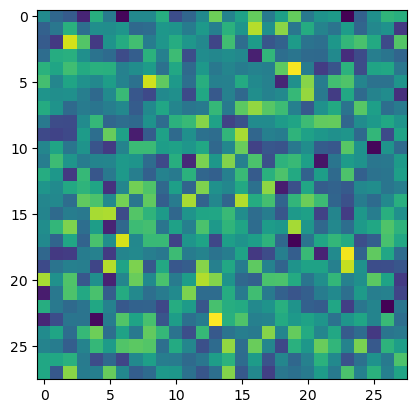

In [8]:
G = Generator()
output = G.forward(torch.rand(1))
img = output.detach().numpy().reshape(28, 28)
plt.imshow(img)

counter =  10000
counter =  20000


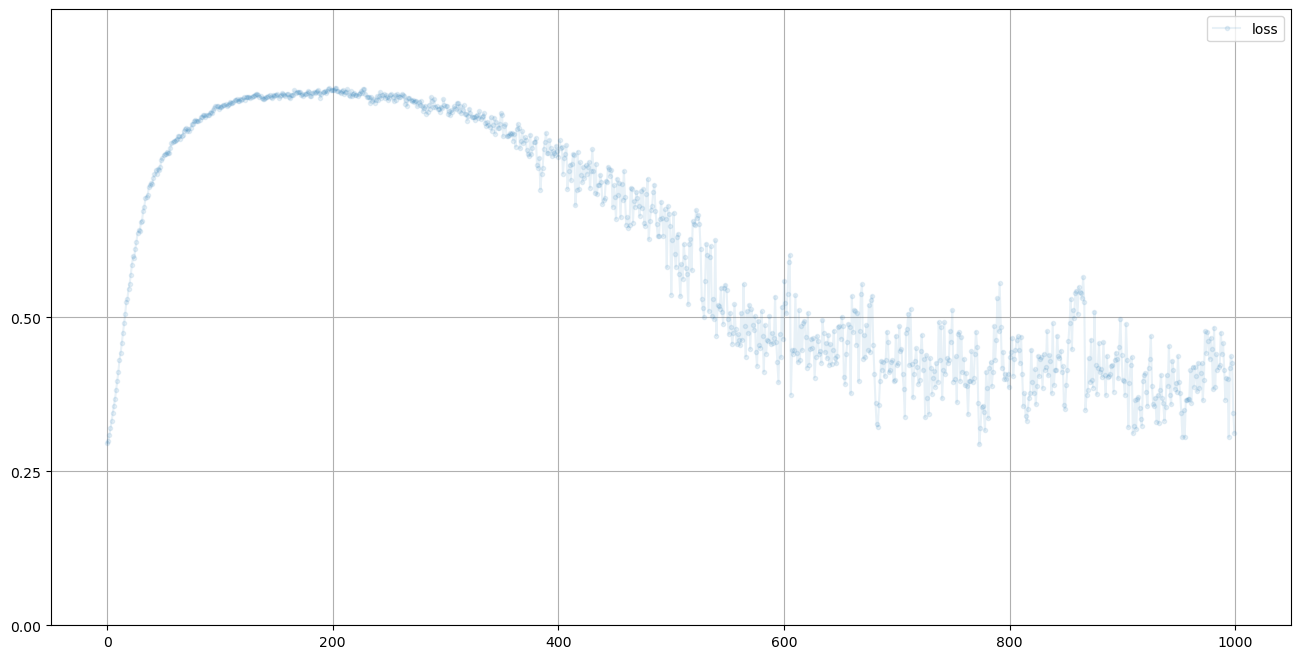

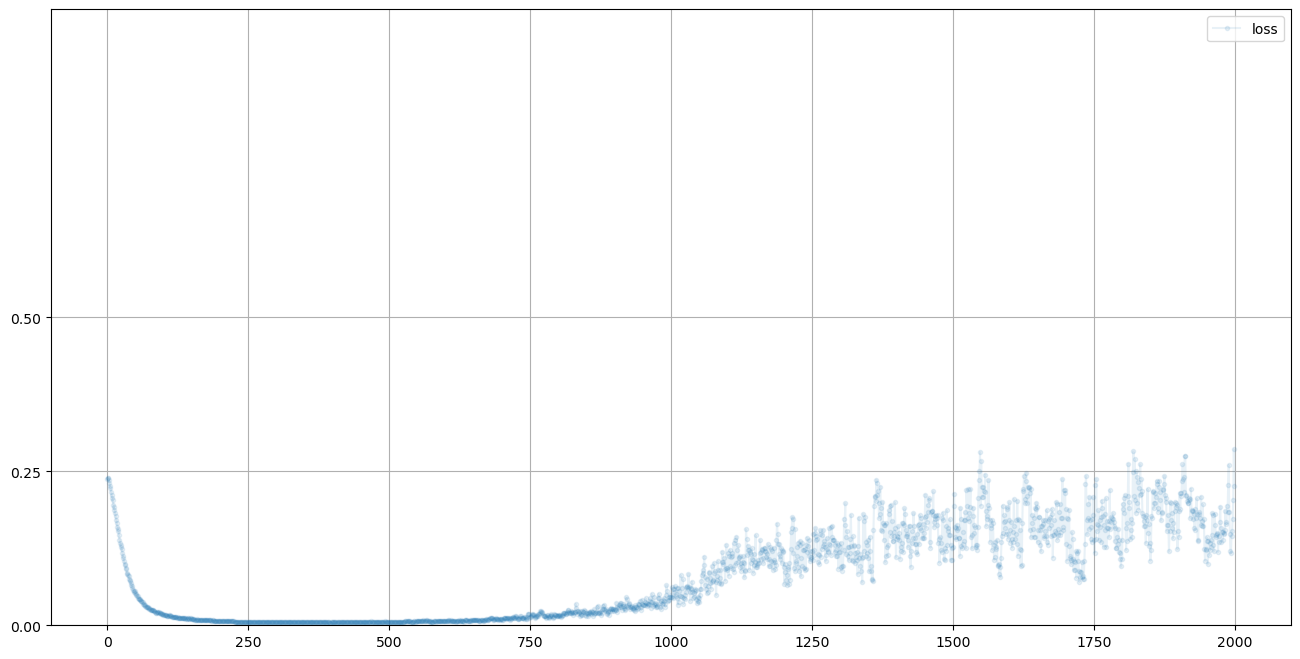

In [11]:
# 训练GAN
D = Discriminator()
G = Generator()

# 训练鉴别器和生成器
for label, image_data_tensor, target_tensor in mnist_datset:
    # 使用真实数据训练鉴别器
    D.train(image_data_tensor, torch.FloatTensor([1.0]))

    # 使用生成样本训练鉴别器
    D.train(G.forward(torch.rand(1)).detach(), torch.FloatTensor([0.0]))

    # 训练生成器
    G.train(D, torch.rand(1), torch.FloatTensor([1.0]))
    

G.plot_grogress()
D.plot_grogress()